 ``plot_trace``関数でワーニングを出さないため次のコマンド実行が必要です。

In [1]:
#!pip install --upgrade numba | tail -n 1

## 5.4 潜在変数モデル

<a href="https://colab.research.google.com/github/makaishi2/python_bayes_intro/blob/main/notebooks/5_4_%E6%BD%9C%E5%9C%A8%E5%A4%89%E6%95%B0%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 共通処理

In [2]:
#%matplotlib inline
# 日本語化ライブラリ導入
#!pip install japanize-matplotlib | tail -n 1

In [3]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [4]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.11.0
Running on ArViz v0.17.1


### 5.4.1 問題設定
アイリスデータセットで特定項目の値のみを利用する。  
花の種別の情報をなしで、2種類の花の統計的特徴を推論する。


### 5.4.2 データ準備

#### データ読み込みと確認

In [5]:
# アイリスデータセットの読み込み
df = sns.load_dataset('iris')

# 先頭5行の確認
display(df.head())

#  speciesの分布確認
df['species'].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

#### 分析対象データの絞り込み


In [6]:
# 花の種類をsetosa以外の２種類に絞り込む
df2 = df.query('species != "setosa"')

# インデックスを0から振り直す
df2 = df2.reset_index(drop=True)

# petal_widthの項目値をx_dataにセット
X = df2['petal_width'].values

#### 分析対象データを色分けなしにヒストグラム表示

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


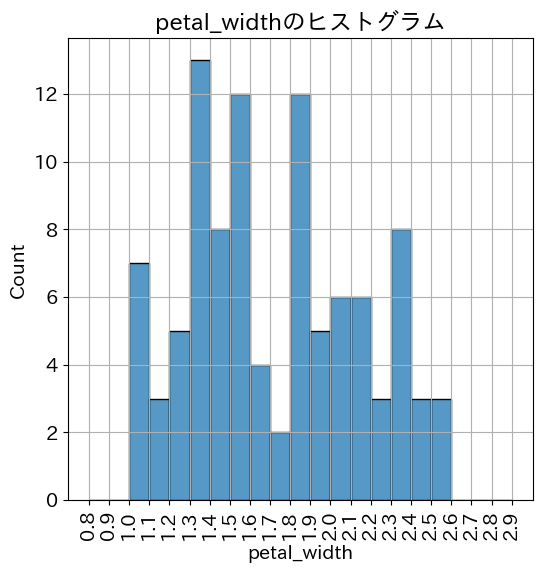

In [7]:
bins = np.arange(0.8, 3.0, 0.1)
fig, ax = plt.subplots()
sns.histplot(bins=bins, x=X)
ax.set_xlabel('petal_width')
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('petal_widthのヒストグラム')
ax.set_xticks(bins);

####  petal_widthのヒストグラム描画(花の種類で色分け)

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1

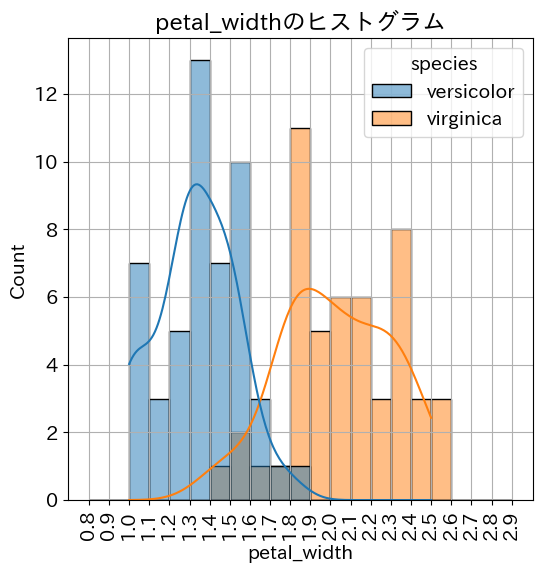

In [8]:
bins = np.arange(0.8, 3.0, 0.1)
fig, ax = plt.subplots()
sns.histplot(data=df2, bins=bins, x='petal_width',
    hue='species', kde=True)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('petal_widthのヒストグラム')
ax.set_xticks(bins);

### 5.4.3 確率モデル定義

#### 潜在変数モデルの確率モデル定義

In [9]:
# 変数の初期設定

# 何種類の正規分布モデルがあるか
n_components = 2

# 観測データ件数
N = X.shape

model1 = pm.Model()

with model1:
    # Xの観測値をConstantDataとして定義
    X_data = pm.ConstantData('X_data', X)

    # p: 潜在変数が1の値をとる確率
    p = pm.Uniform('p', lower=0.0, upper=1.0)

    # s: 潜在変数pの確率値をもとに0, 1のいずれかの値を返す
    s = pm.Bernoulli('s', p=p, shape=N)

    # mus: ２つの花の種類毎の平均値
    mus = pm.Normal('mus', mu=0.0, sigma=10.0, shape=n_components)

    # taus: 2つの花の種類毎のバラツキ
    # 標準偏差sigmasとの間にはtaus = 1/(sigmas*sigmas)の関係がある
    taus = pm.HalfNormal('taus', sigma=10.0, shape=n_components)

    # グラフ描画など分析でsigmasが必要なため、tausからsigmasを求めておく
    sigmas = pm.Deterministic('sigmas', 1/pm.math.sqrt(taus))

    # 各観測値ごとに潜在変数からmuとtauを求める
    mu = pm.Deterministic('mu', mus[s])
    tau = pm.Deterministic('tau', taus[s])

    # 正規分布に従う確率変数X_obsの定義
    X_obs = pm.Normal('X_obs', mu=mu, tau=tau, observed=X_data)

#### 確率モデル構造可視化

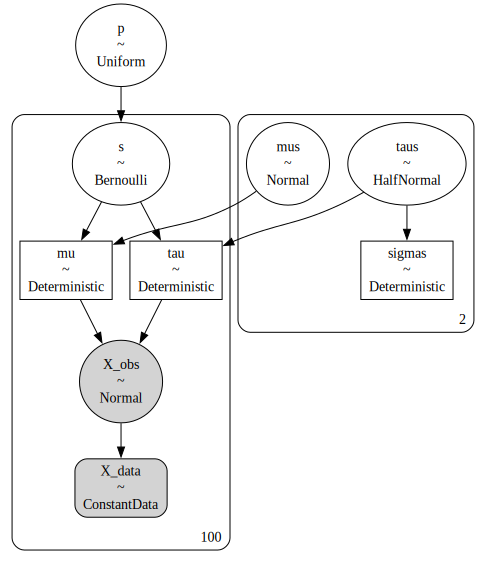

In [10]:
g = pm.model_to_graphviz(model1)
display(g)

### 5.4.4 サンプリングと結果分析

#### サンプリング

In [11]:
with model1:
    idata1 = pm.sample(chains=1, draws=2000, target_accept=0.99,
      random_seed=42)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, taus]
>BinaryGibbsMetropolis: [s]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 28 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


#### plot_trace関数で推論結果の確認

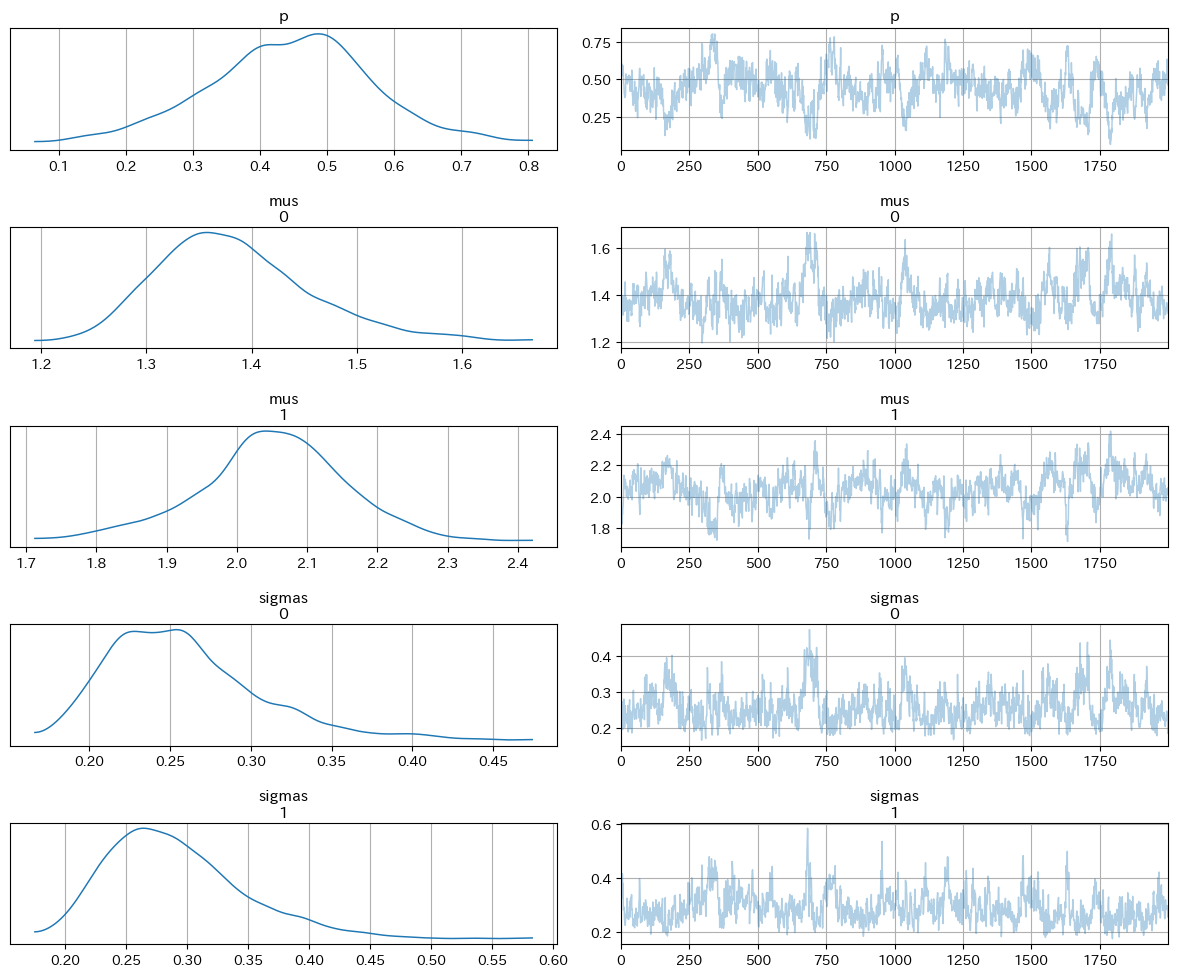

In [12]:
az.plot_trace(idata1, var_names=['p', 'mus', 'sigmas'], compact=False)
plt.tight_layout();

#### plot_posterior関数で各確率変数の事後分布の確認

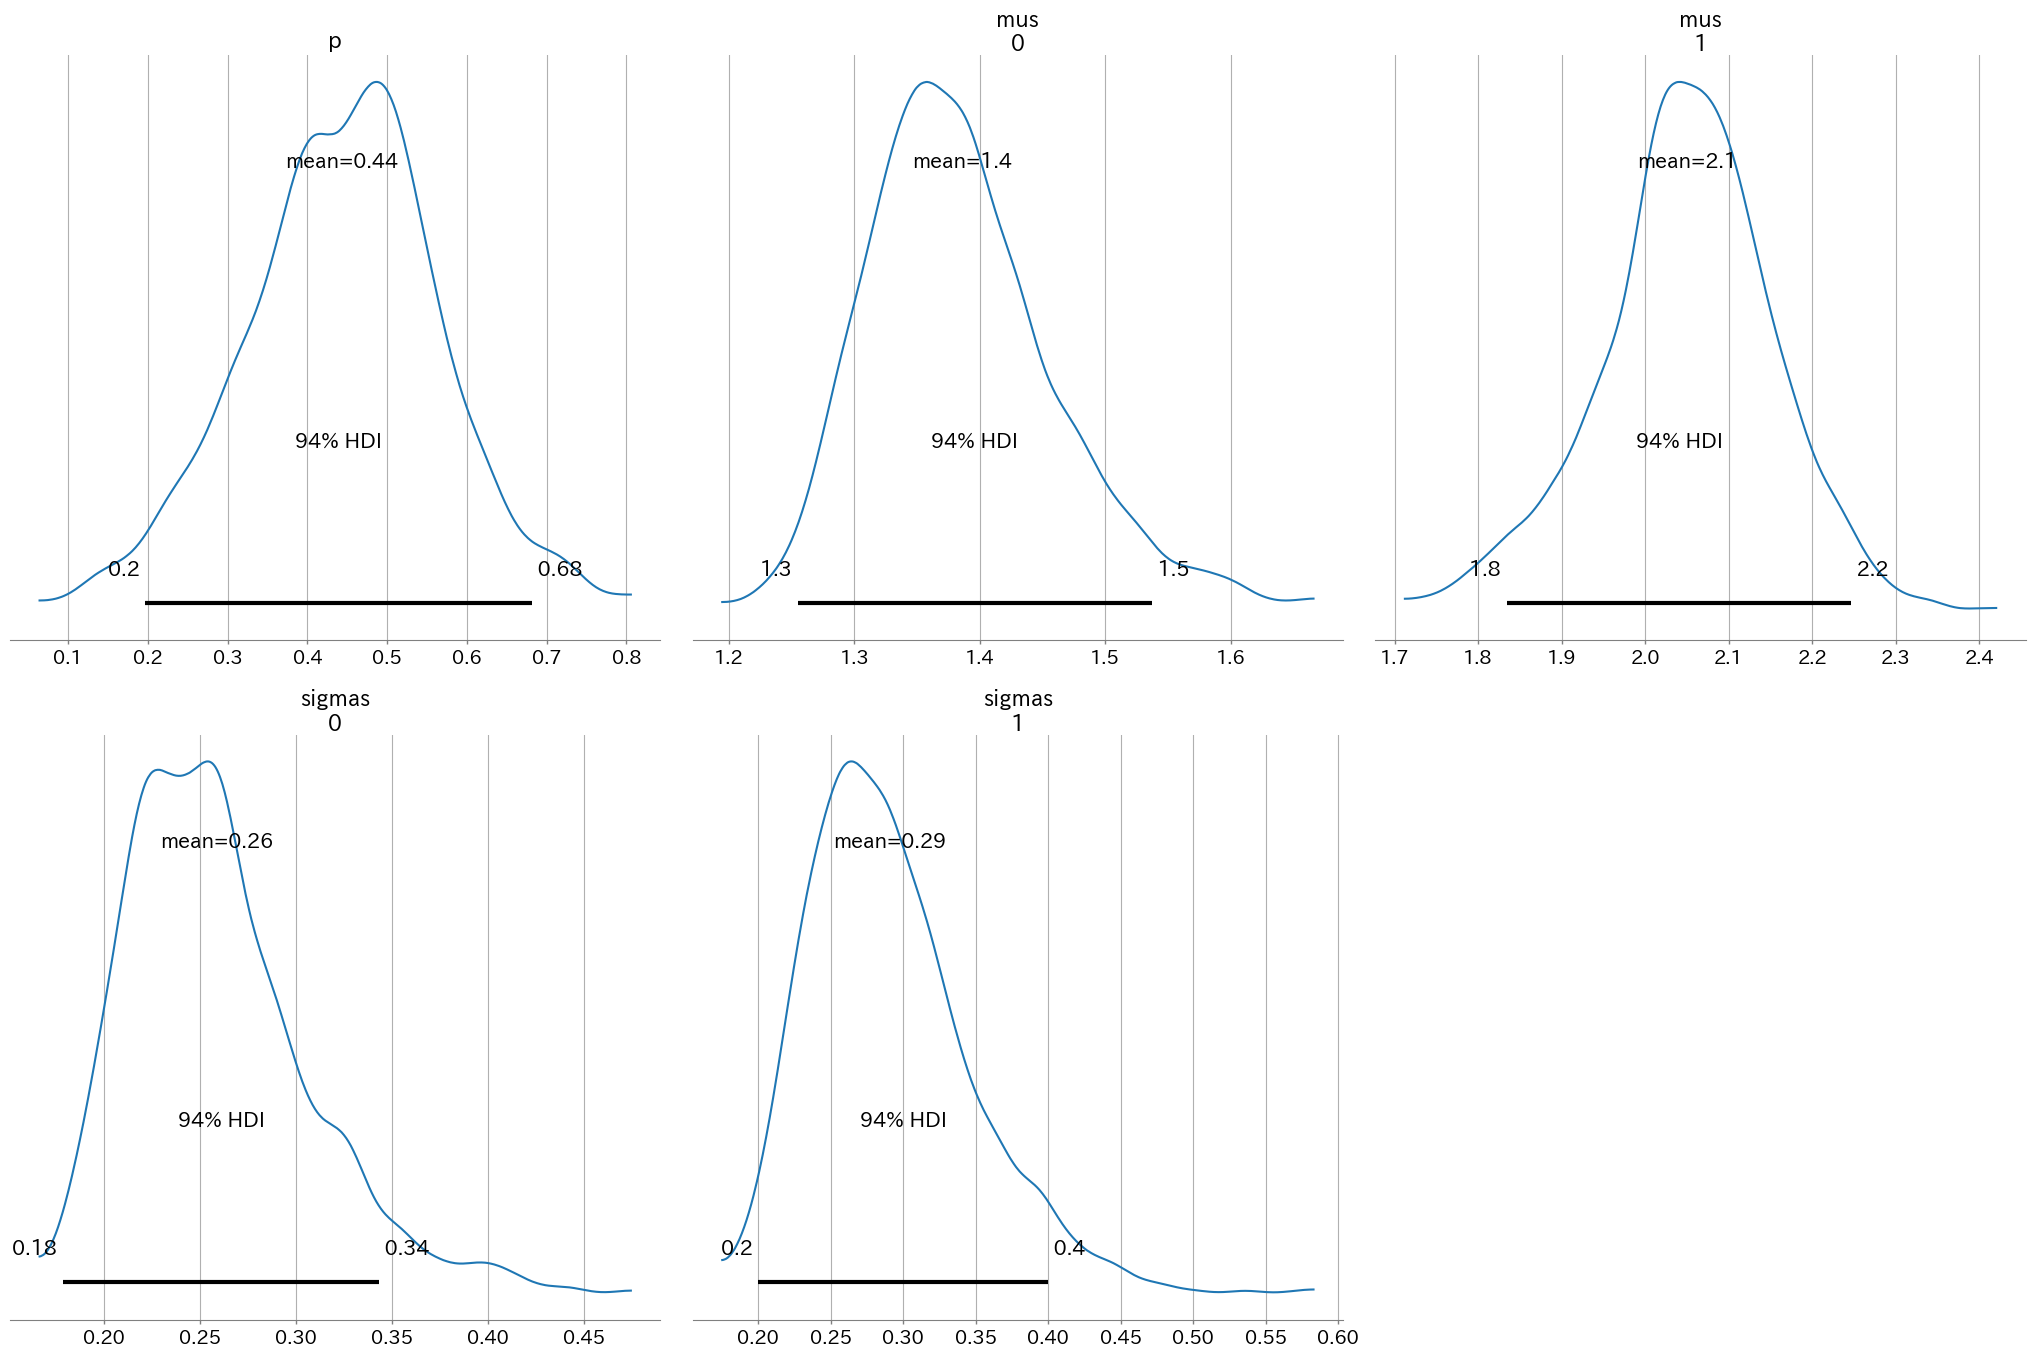

In [13]:
plt.rcParams['figure.figsize']=(6,6)
az.plot_posterior(idata1, var_names=['p', 'mus', 'sigmas'])
plt.tight_layout();

#### summary関数で統計情報の取得

In [14]:
summary1 = az.summary(idata1, var_names=['p', 'mus', 'sigmas'])
display(summary1)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.443,0.125,0.197,0.682,0.015,0.011,66.000,148.000,NaN
mus[0],1.386,0.077,1.255,1.538,0.009,0.006,82.000,113.000,NaN
mus[1],2.050,0.107,1.834,2.247,0.013,0.009,69.000,135.000,NaN
sigmas[0],0.259,0.047,0.178,0.343,0.005,0.004,106.000,139.000,NaN
sigmas[1],0.291,0.056,0.200,0.400,0.006,0.004,88.000,294.000,NaN


### 5.4.5 ヒストグラムと正規分布関数の重ね描き

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1

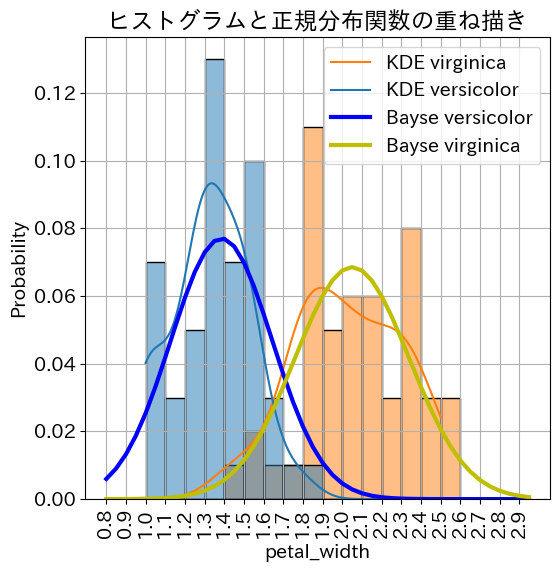

In [15]:
# 正規分布関数の定義
def norm(x, mu, sigma):
    return np.exp(-((x - mu)/sigma)**2/2) / (np.sqrt(2 * np.pi) * sigma)

# 推論結果から各パラメータの平均値を取得
mean = summary1['mean']

# muの平均値取得
mean_mu0 = mean['mus[0]']
mean_mu1 = mean['mus[1]']

# sigmaの平均値取得
mean_sigma0 = mean['sigmas[0]']
mean_sigma1 = mean['sigmas[1]']

# 正規分布関数値の計算
x = np.arange(0.8, 3.0, 0.05)
delta = 0.1
y0 = norm(x, mean_mu0, mean_sigma0) * delta / n_components
y1 = norm(x, mean_mu1, mean_sigma1) * delta / n_components

# グラフ描画
bins = np.arange(0.8, 3.0, delta)
plt.rcParams['figure.figsize']=(6,6)
fig, ax = plt.subplots()
sns.histplot(data=df2, bins=bins, x='petal_width',
    hue='species', kde=True, ax=ax,  stat='probability')
ax.get_lines()[1].set_label('KDE versicolor')
ax.get_lines()[0].set_label('KDE virginica')
ax.plot(x, y0, c='b', lw=3, label='Bayse versicolor')
ax.plot(x, y1, c='y', lw=3, label='Bayse virginica')
ax.set_xticks(bins);
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('ヒストグラムと正規分布関数の重ね描き')
plt.legend();

### 5.4.6 潜在変数の確率分布

#### petal_widthの値が1.0, 1.5, 1.7, 2.0, 2.5のインデックスを調べる

In [16]:
value_list = [1.0, 1.5, 1.7, 2.0, 2.5]

df_heads = pd.DataFrame(None)

# petal_widthの値が1.0から2.5までそれぞれの値である先頭の行を抽出
for value in value_list:

    # df2からpetal_widthの値がvalueである行のみ抽出
    w = df2.query('petal_width == @value', engine='python')

    # 先頭の１行を抽出し、df_headsに連結
    df_heads = pd.concat([df_heads, w.head(1)], axis=0)

# 結果確認
display(df_heads)

,sepal_length,sepal_width,petal_length,petal_width,species
7,4.900,2.400,3.300,1.000,versicolor
1,6.400,3.200,4.500,1.500,versicolor
27,6.700,3.000,5.000,1.700,versicolor
60,6.500,3.200,5.100,2.000,virginica
50,6.300,3.300,6.000,2.500,virginica


#### petal_widthの値の違いによる潜在変数sの確率分布の可視化

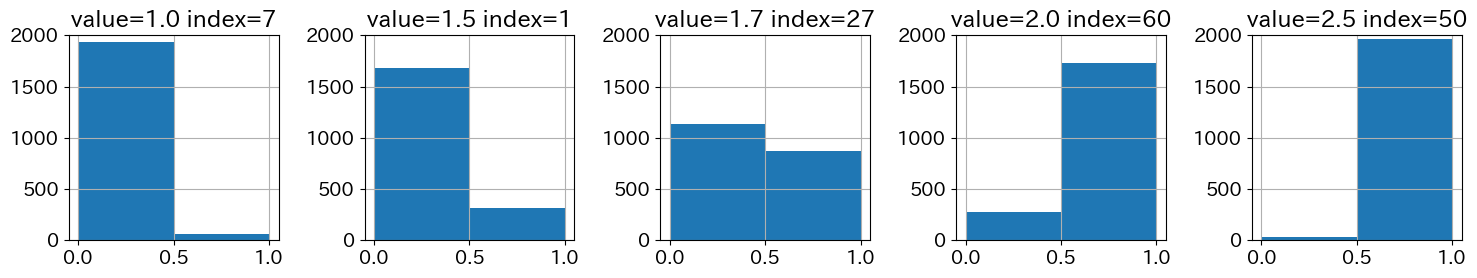

In [17]:
# df_headsのインデックスを抽出
indexes, n_indexes = df_heads.index, len(df_heads)

# 潜在変数sのサンプル値から、index=7, 1, 27, 60, 50の値を抽出
sval = idata1.posterior['s'][:,:,indexes].values.reshape(-1,n_indexes).T

# それぞれのケースでヒストグラムの描画
plt.rcParams['figure.figsize']=(15,3)
vlist = df_heads['petal_width']
fig, axes = plt.subplots(1, n_indexes)
for ax, item, value, index in zip(axes, sval, vlist, indexes):
    f = pd.DataFrame(item)
    f.hist(ax=ax, bins=2)
    ax.set_ylim(0,2000)
    ax.set_title(f'value={value} index={index}')
plt.tight_layout();

 ### コラム　潜在変数モデルにおけるベイズ推論のツボ

#### 意図しない結果になる確率モデル

##### 確率モデル定義

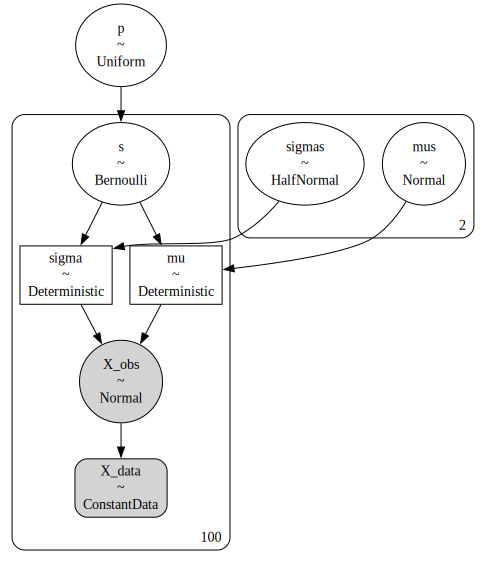

In [18]:
model2 = pm.Model()

with model2:
    # Xの観測値をConstantDataとして定義
    X_data = pm.ConstantData('X_data', X)

    # p: 潜在変数が1の値をとる確率
    p = pm.Uniform('p', lower=0.0, upper=1.0)

    # s: 潜在変数　pの確率値をもとに0, 1のいずれかの値を返す
    s = pm.Bernoulli('s', p=p, shape=N)

    # mus: ２つの花の種類毎の平均値
    mus = pm.Normal('mus', mu=0.0, sigma=10.0, shape=n_components)

    # sigmas: 2つの花の種類毎のバラツキ
    sigmas = pm.HalfNormal('sigmas', sigma=10.0, shape=n_components)

    # 各観測値ごとに潜在変数から平均値と標準偏差を求める
    mu = pm.Deterministic('mu', mus[s])
    sigma = pm.Deterministic('sigma', sigmas[s])

    # 正規分布によりxの値を求める
    X_obs = pm.Normal('X_obs', mu=mu, sigma=sigma, observed=X_data)

# 確率モデル構造可視化
g = pm.model_to_graphviz(model2)
display(g)

##### サンプリングとplot_trace関数呼び出し

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, sigmas]
>BinaryGibbsMetropolis: [s]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 57 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


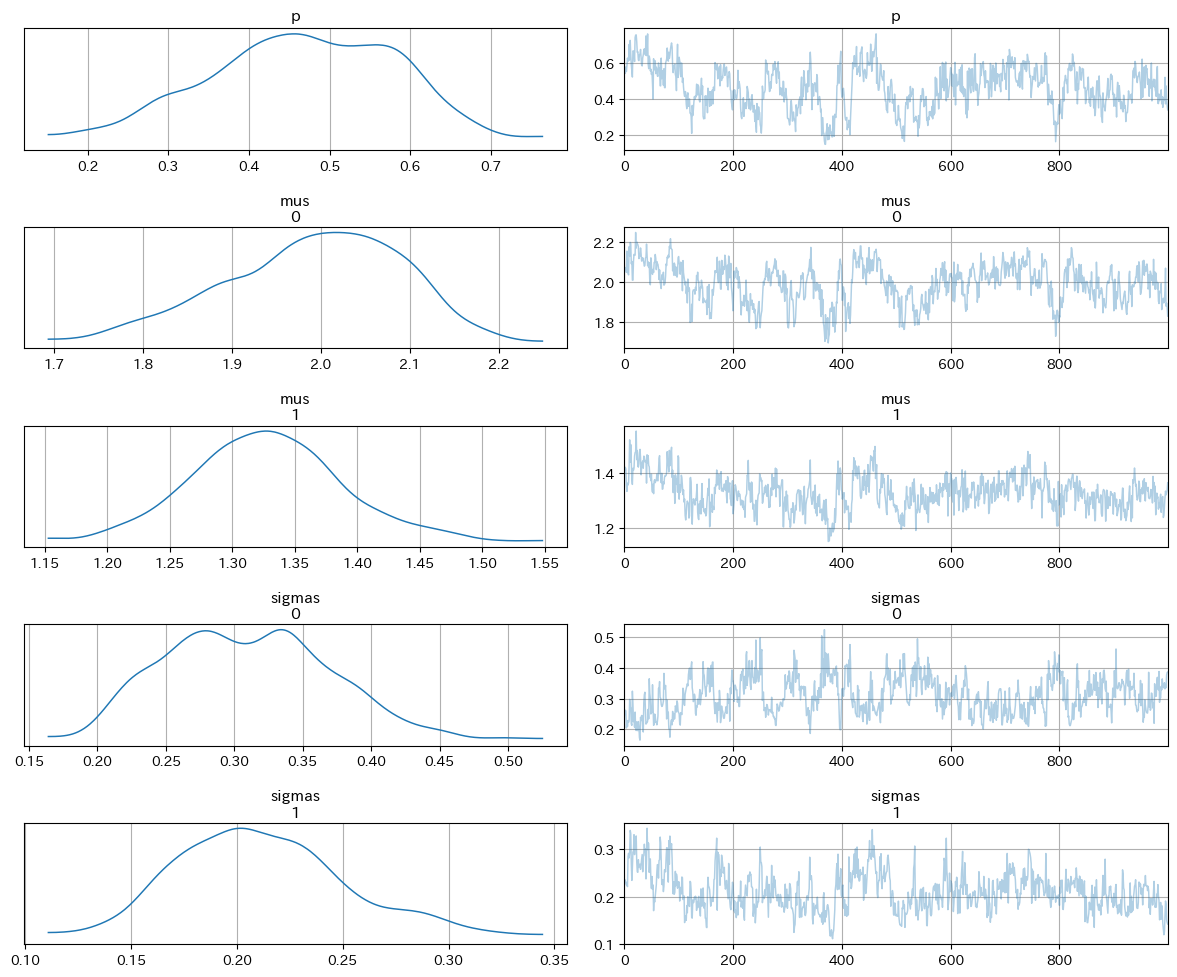

In [19]:
with model2:
    # サンプリング
    idata2 = pm.sample(random_seed=42, chains=1, target_accept=0.998)

# plot_trace関数で推論結果の確認
az.plot_trace(idata2, var_names=['p', 'mus', 'sigmas'], compact=False)
plt.tight_layout();

In [20]:
summary2 = az.summary(idata2, var_names=['p', 'mus', 'sigmas'])
display(summary2)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.465,0.118,0.255,0.680,0.020,0.015,34.000,36.000,NaN
mus[0],1.991,0.098,1.786,2.149,0.015,0.011,39.000,101.000,NaN
mus[1],1.328,0.060,1.214,1.445,0.010,0.008,35.000,28.000,NaN
sigmas[0],0.310,0.060,0.200,0.409,0.008,0.005,60.000,170.000,NaN
sigmas[1],0.212,0.041,0.142,0.295,0.008,0.006,33.000,149.000,NaN


#### ラベルスイッチが起きない確率モデル

##### 確率モデル定義

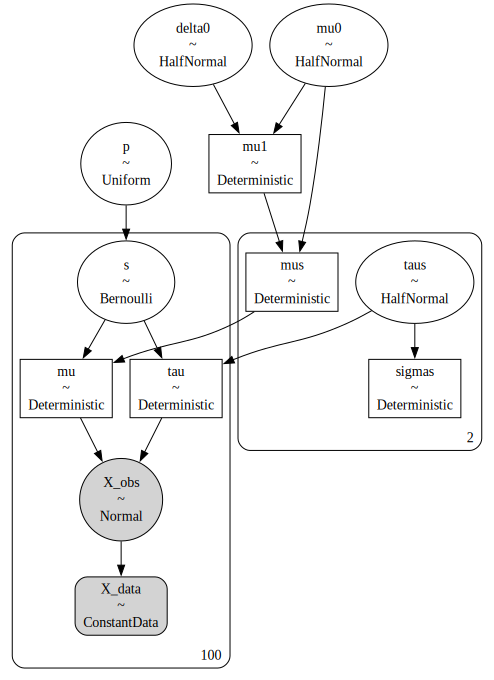

In [21]:
# 変数の初期設定

# 何種類の正規分布モデルがあるか
n_components = 2

# 観測データ件数
N = X.shape

model3 = pm.Model()

with model3:
    # Xの観測値をConstantDataとして定義
    X_data = pm.ConstantData('X_data', X)

    # p: 潜在変数が1の値をとる確率
    p = pm.Uniform('p', lower=0.0, upper=1.0)

    # s: 潜在変数　pの確率値をもとに0, 1のいずれかの値を返す
    s = pm.Bernoulli('s', p=p, shape=N)

    # mus: ２つの花の種類毎の平均値
    mu0 = pm.HalfNormal('mu0', sigma=10.0)
    delta0 = pm.HalfNormal('delta0', sigma=10.0)
    mu1 = pm.Deterministic('mu1', mu0+delta0)
    mus = pm.Deterministic('mus',pm.math.stack([mu0, mu1]))

    # taus: 2つの花の種類毎のバラツキ
    # 標準偏差sigmasとの間にはtaus = 1/(sigmas*sigmas)の関係がある
    taus = pm.HalfNormal('taus', sigma=10.0, shape=n_components)

    # グラフ描画など分析でsigmasが必要なため、tausからsigmasを求めておく
    sigmas = pm.Deterministic('sigmas', 1/pm.math.sqrt(taus))

    # 各観測値ごとに潜在変数からmuとtauを求める
    mu = pm.Deterministic('mu', mus[s])
    tau = pm.Deterministic('tau', taus[s])

    # 正規分布に従う確率変数X_obsの定義
    X_obs = pm.Normal('X_obs', mu=mu, tau=tau, observed=X_data)

g = pm.model_to_graphviz(model3)
display(g)

##### サンプリングとplot_trace関数呼び出し

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, mu0, delta0, taus]
>BinaryGibbsMetropolis: [s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


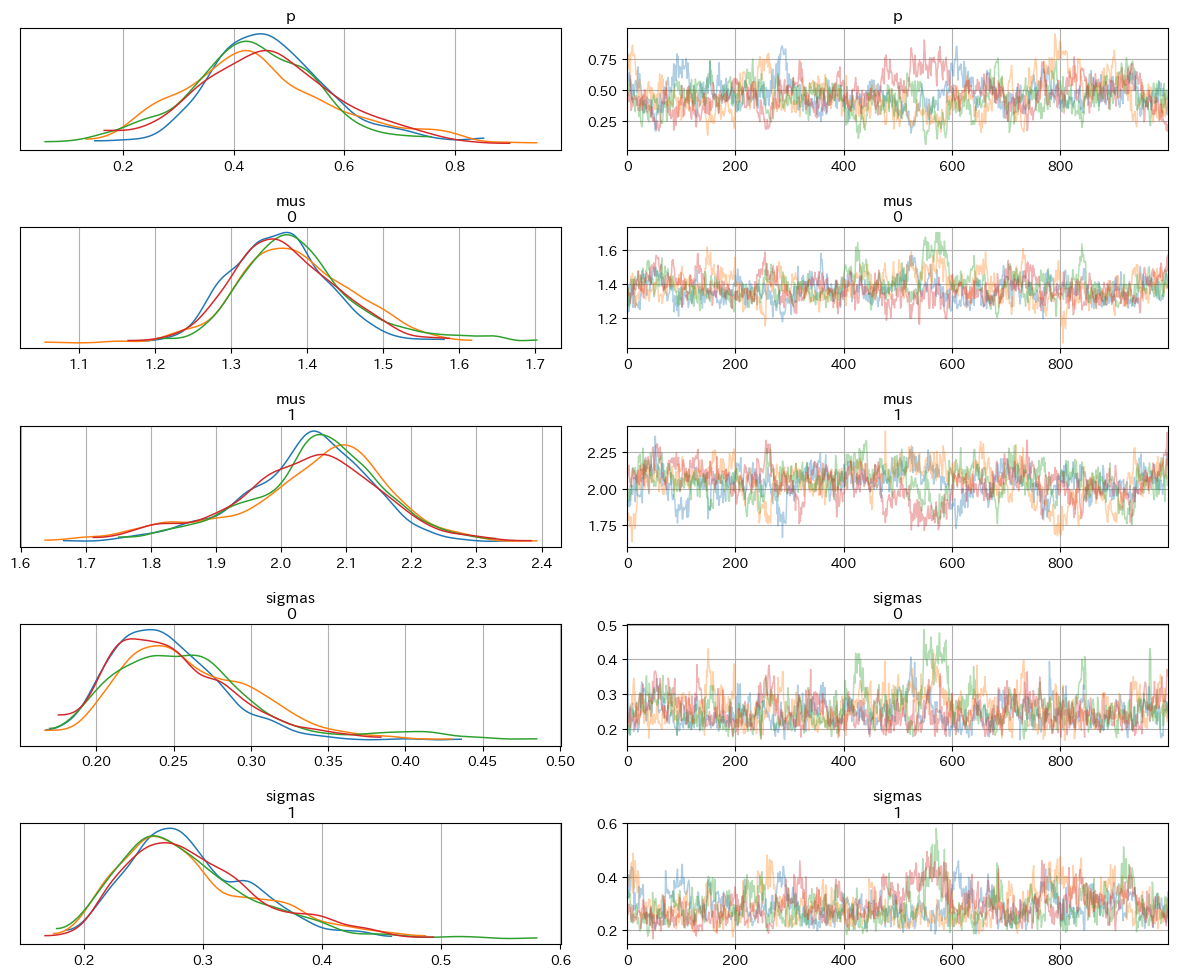

In [22]:
with model3:
    # サンプリング
    idata3 = pm.sample(random_seed=42, target_accept=0.999)

# plot_trace関数で推論結果の確認
az.plot_trace(idata3, var_names=['p', 'mus', 'sigmas'], compact=False)
plt.tight_layout();

In [23]:
summary3 = az.summary(idata3, var_names=['p', 'mus', 'sigmas'])
display(summary3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.454,0.127,0.212,0.710,0.012,0.009,110.000,236.000,1.020
mus[0],1.379,0.074,1.254,1.529,0.006,0.004,163.000,235.000,1.020
mus[1],2.043,0.108,1.810,2.226,0.010,0.007,113.000,246.000,1.020
sigmas[0],0.254,0.044,0.177,0.330,0.003,0.002,238.000,305.000,1.020
sigmas[1],0.291,0.057,0.198,0.399,0.005,0.003,142.000,273.000,1.020


##### グラフ描画

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1

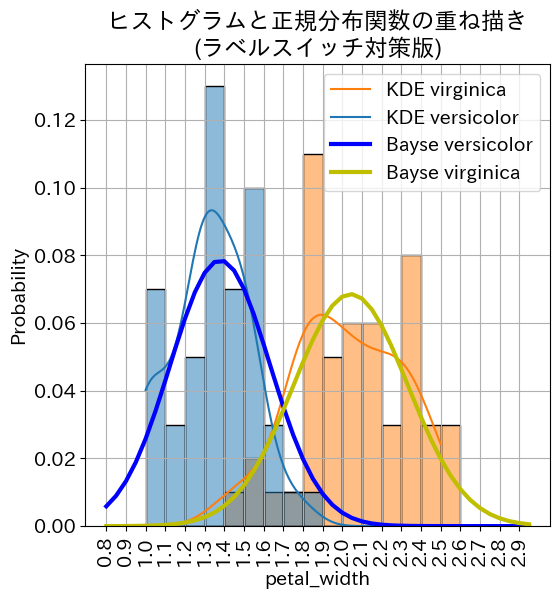

In [24]:
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)

# 正規分布関数の定義
def norm(x, mu, sigma):
    return np.exp(-((x - mu)/sigma)**2/2) / (np.sqrt(2 * np.pi) * sigma)

# 推論結果から各パラメータの平均値を取得
mean = summary3['mean']

# muの平均値取得
mean_mu0 = mean['mus[0]']
mean_mu1 = mean['mus[1]']

# sigmaの平均値取得
mean_sigma0 = mean['sigmas[0]']
mean_sigma1 = mean['sigmas[1]']

# 正規分布関数値の計算
y0 = norm(x, mean_mu0, mean_sigma0) * delta / n_components
y1 = norm(x, mean_mu1, mean_sigma1) * delta / n_components

# グラフ描画
delta = 0.1
bins = np.arange(0.8, 3.0, delta)
x = np.arange(0.8, 3.0, 0.05)
plt.rcParams['figure.figsize']=(6,6)
fig, ax = plt.subplots()
sns.histplot(data=df2, bins=bins, x='petal_width',
    hue='species', kde=True, ax=ax, stat='probability')
ax.get_lines()[1].set_label('KDE versicolor')
ax.get_lines()[0].set_label('KDE virginica')
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('ヒストグラムと正規分布関数の重ね描き\n(ラベルスイッチ対策版)')
ax.set_xticks(bins);
ax.plot(x, y0, c='b', lw=3, label='Bayse versicolor')
ax.plot(x, y1, c='y', lw=3, label='Bayse virginica')
plt.legend();

#### バージョンの確認

In [25]:
#!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

matplotlib         : 3.8.3
pandas             : 2.2.1
pymc               : 5.11.0
japanize_matplotlib: 1.1.3
numpy              : 1.26.4
arviz              : 0.17.1
seaborn            : 0.12.2

